# 1. 데이터 준비

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

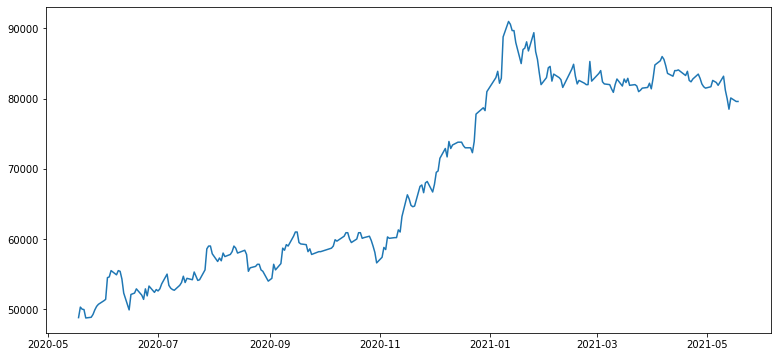

In [2]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

# 2. 전처리

In [3]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

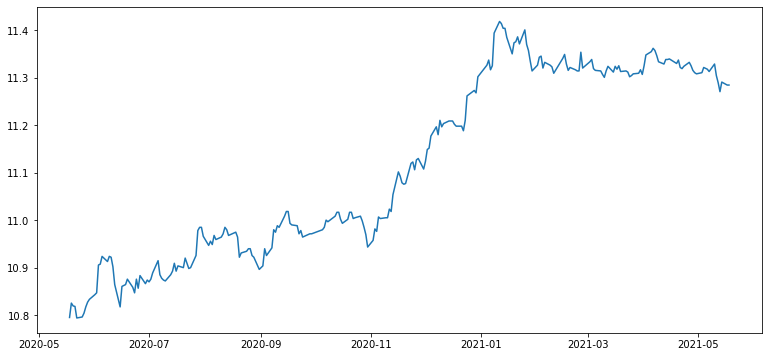

In [5]:
# 로그 변환 시도 
ts_log = np.log(ts)
plt.plot(ts_log)

# 3. 시계열 안정성 분석

In [10]:
# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화하는 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

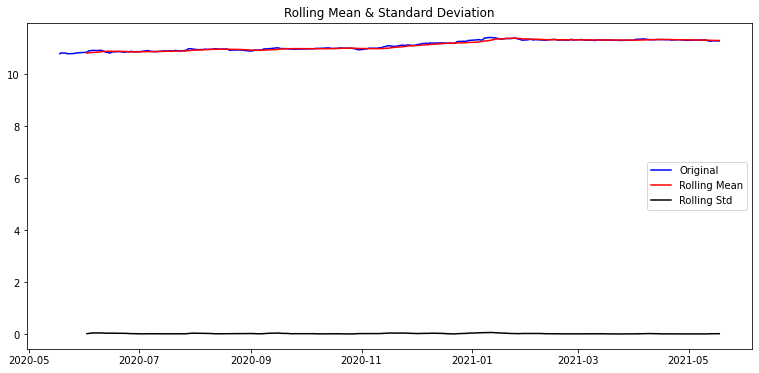

In [11]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [12]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [13]:
# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


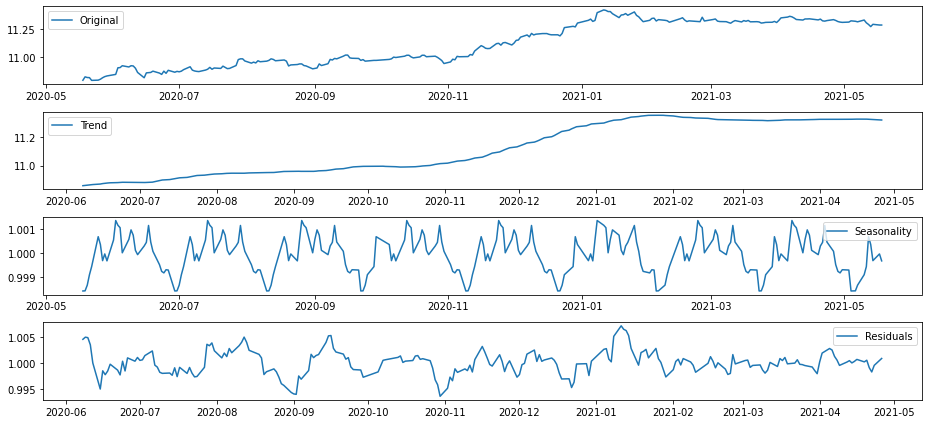

In [14]:
# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (13,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

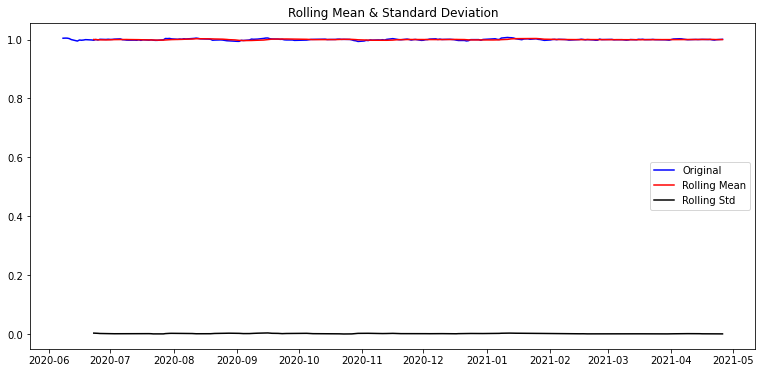

In [15]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [16]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


# 4. 학습, 테스트 데이터셋 생성

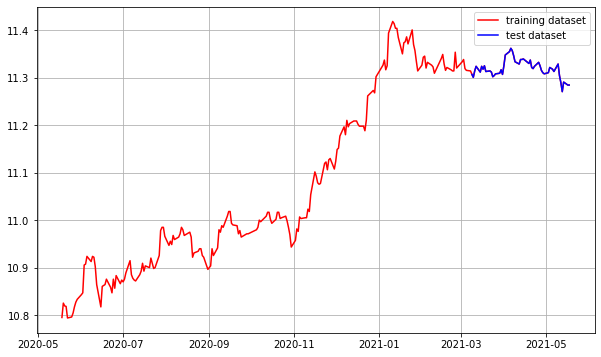

In [18]:
train_data, test_data = ts_log[:int(len(ts_log)*0.8)], ts_log[int(len(ts_log)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# 5. 적정 ARIMA 모수 찾기

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


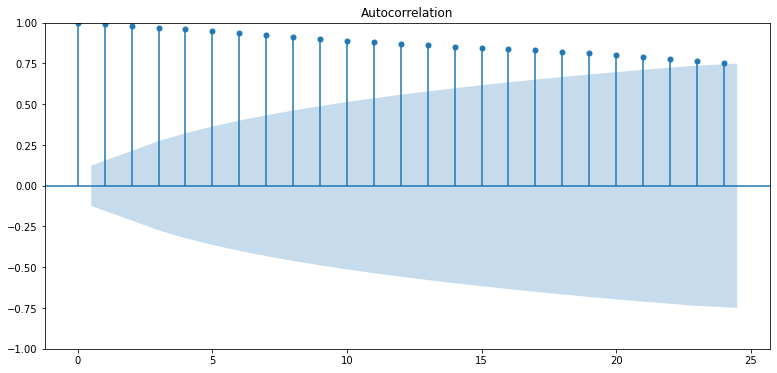

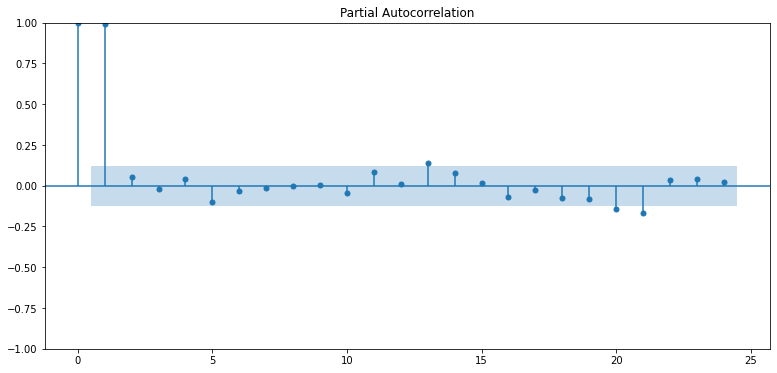

In [19]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


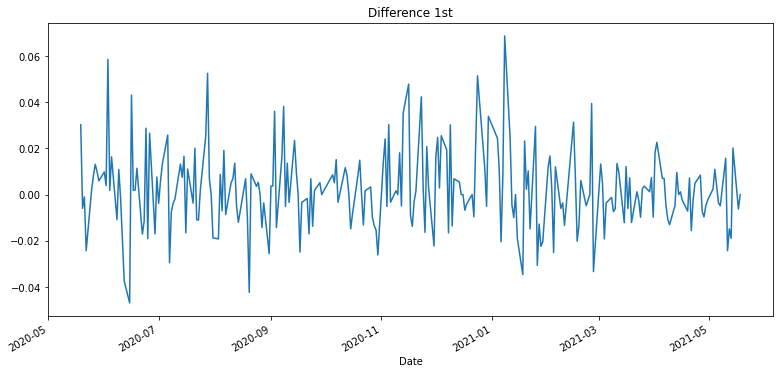

In [20]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


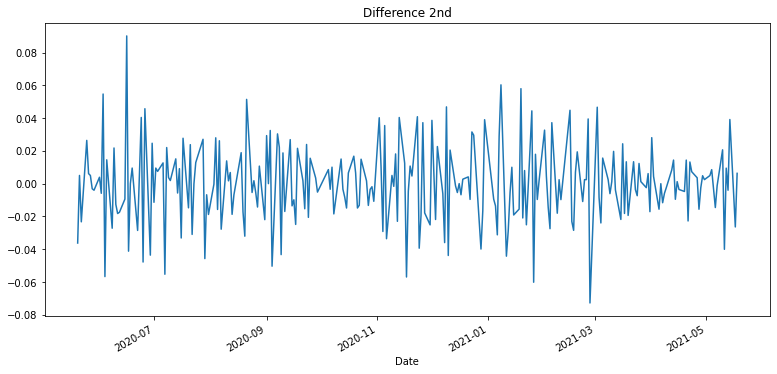

In [21]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# 6. ARIMA 모델 훈련과 테스트

In [23]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  200
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 510.090
Date:                Thu, 17 Feb 2022   AIC                          -1010.179
Time:                        11:35:54   BIC                           -993.688
Sample:                             0   HQIC                         -1003.506
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0604      0.142     77.663      0.000      10.781      11.340
ar.L1          0.6478      1.803      0.359      0.719      -2.885       4.181
ar.L2          0.3453      1.794      0.193      0.8

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


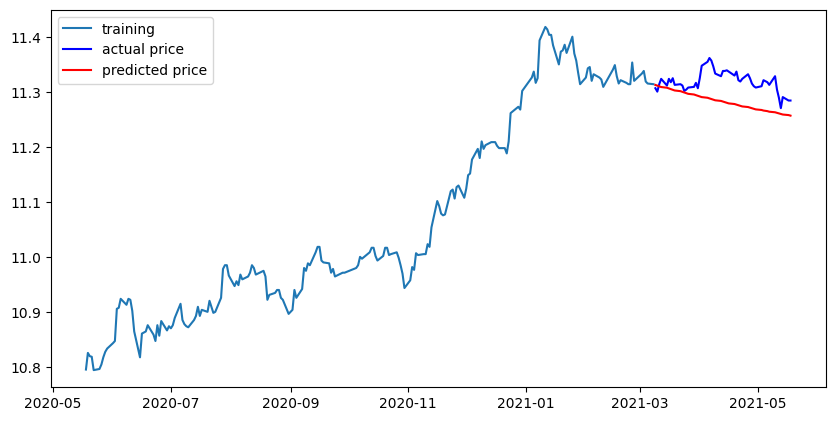

In [24]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  11481312.386692274
MAE:  2920.6840973811545
RMSE:  3388.4085330273083
MAPE: 3.52%


# 7. 다른 주식 종목 예측해 보기(NVIDIA, TESLA, ASML)

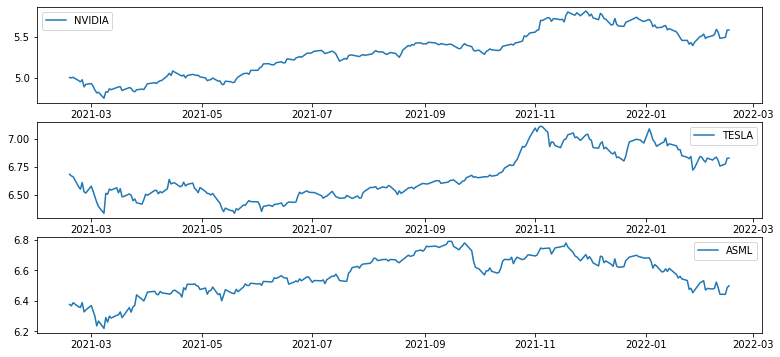

In [32]:
# 데이터 불러와 Time Series 생성하기
NVIDIA_dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/NVDA.csv'
TESLA_dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/TSLA.csv'
ASML_dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/ASML.csv'

df_NVIDIA = pd.read_csv(NVIDIA_dataset_filepath, index_col='Date', parse_dates=True)
df_TESLA = pd.read_csv(TESLA_dataset_filepath, index_col='Date', parse_dates=True)
df_ASML = pd.read_csv(ASML_dataset_filepath, index_col='Date', parse_dates=True)

ts_NVIDIA = df_NVIDIA['Close']
ts_TESLA = df_TESLA['Close']
ts_ASML = df_ASML['Close']

# 로그 변환 시도 
ts_NVIDIA = np.log(ts_NVIDIA)
ts_TESLA = np.log(ts_TESLA)
ts_ASML = np.log(ts_ASML)

plt.subplot(311)
plt.plot(ts_NVIDIA, label = 'NVIDIA')
plt.legend(loc='best')
#plt.gca().title.set_text('NVIDIA')
plt.subplot(312)
plt.plot(ts_TESLA, label = 'TESLA')
plt.legend(loc='best')
#plt.gca().title.set_text('TESLA')
plt.subplot(313)
plt.plot(ts_ASML, label = 'ASML')
plt.legend(loc='best')
#plt.gca().title.set_text('ASML')

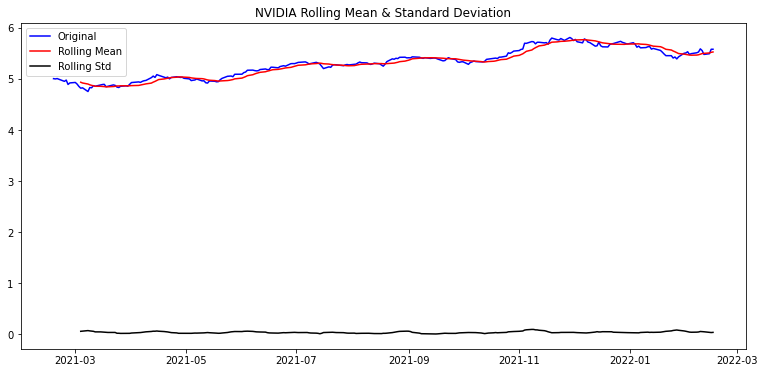

Results of Dickey-Fuller Test:
Test Statistic                  -1.433994
p-value                          0.565875
#Lags Used                       6.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


In [39]:
# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화하는 함수
def plot_rolling_statistics_2(timeseries, window=12, name = ''):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(name + ' ' + 'Rolling Mean & Standard Deviation')
    plt.show(block=False)

# 정성적 그래프 분석
plot_rolling_statistics_2(ts_NVIDIA, window=12, name='NVIDIA')

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_NVIDIA)

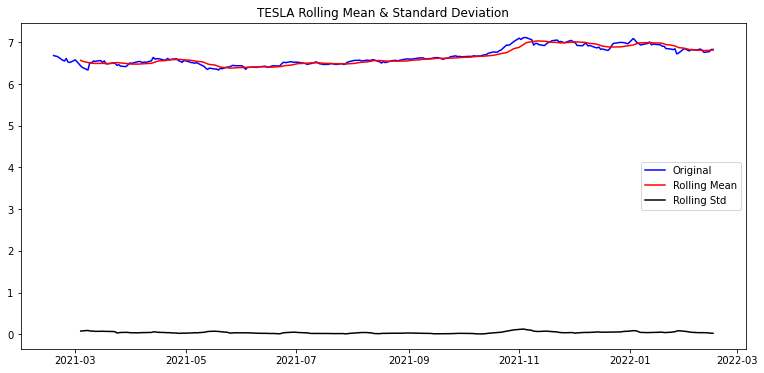

Results of Dickey-Fuller Test:
Test Statistic                  -1.253137
p-value                          0.650330
#Lags Used                       0.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


In [38]:
# 정성적 그래프 분석
plot_rolling_statistics_2(ts_TESLA, window=12, name='TESLA')

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_TESLA)

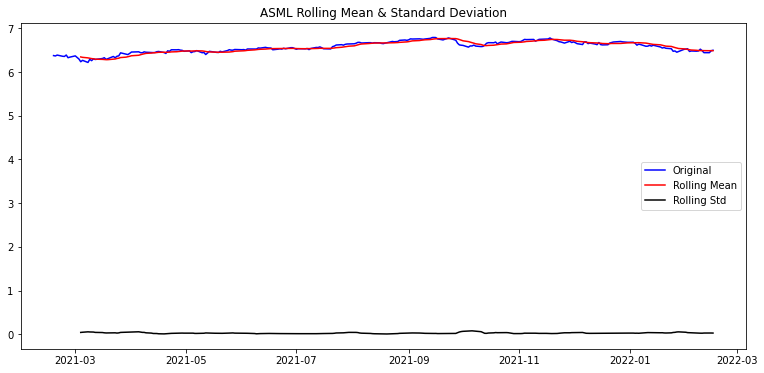

In [36]:
# 정성적 그래프 분석
plot_rolling_statistics_2(ts_ASML, window=12, name='ASML')

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_ASML)

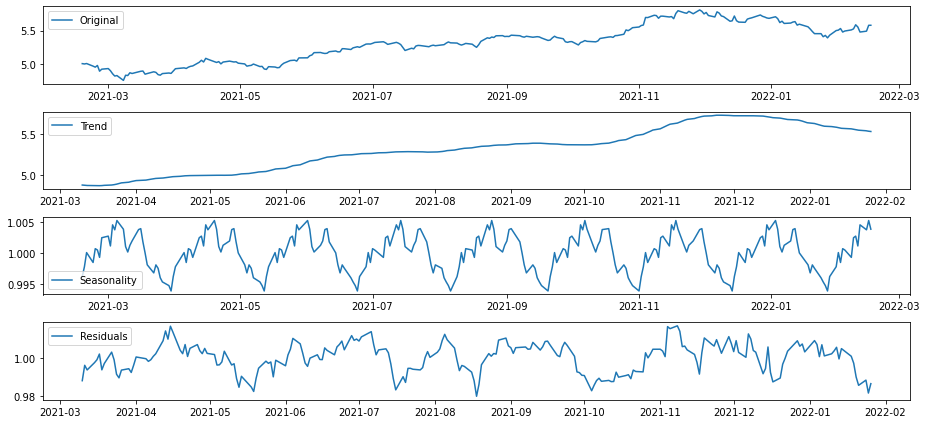

In [40]:
decomposition_NVIDIA = seasonal_decompose(ts_NVIDIA, model='multiplicative', period = 30) 

trend_NVIDIA = decomposition_NVIDIA.trend
seasonal_NVIDIA = decomposition_NVIDIA.seasonal
residual_NVIDIA = decomposition_NVIDIA.resid

plt.rcParams["figure.figsize"] = (13,6)
plt.subplot(411)
plt.plot(ts_NVIDIA, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_NVIDIA, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_NVIDIA,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_NVIDIA, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

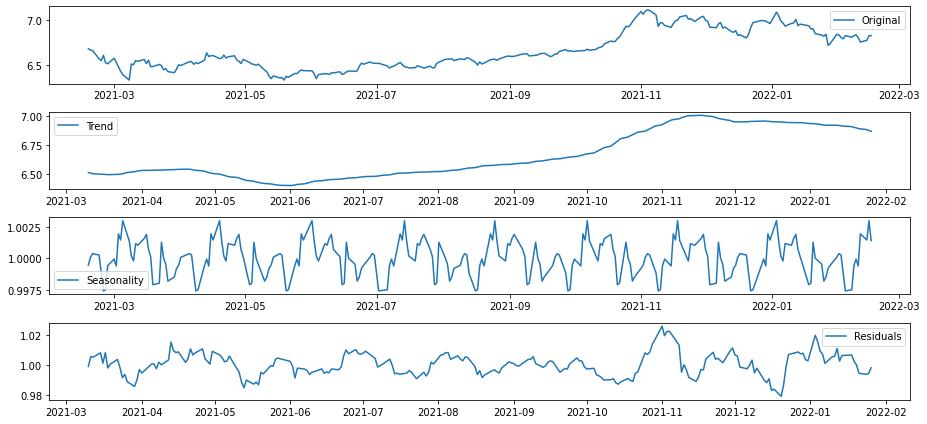

In [43]:
decomposition_TESLA = seasonal_decompose(ts_TESLA, model='multiplicative', period = 30) 

trend_TESLA = decomposition_TESLA.trend
seasonal_TESLA = decomposition_TESLA.seasonal
residual_TESLA = decomposition_TESLA.resid

plt.rcParams["figure.figsize"] = (13,6)
plt.subplot(411)
plt.plot(ts_TESLA, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_TESLA, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_TESLA,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_TESLA, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

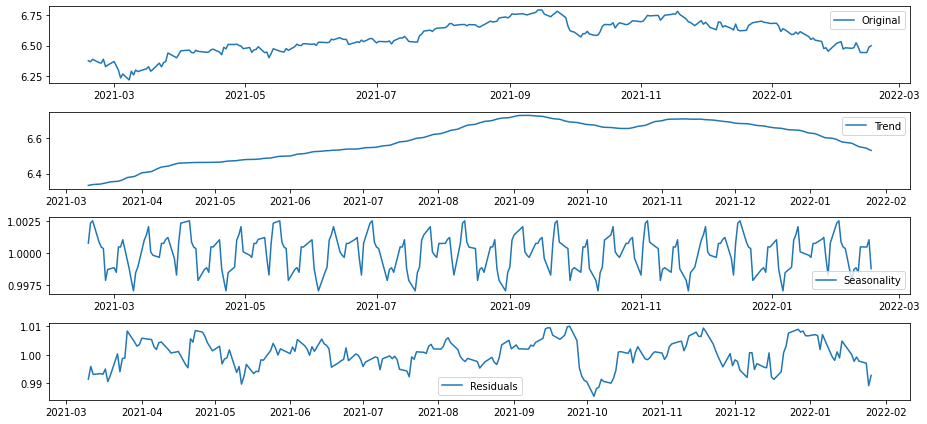

In [44]:
decomposition_ASML = seasonal_decompose(ts_ASML, model='multiplicative', period = 30) 

trend_ASML = decomposition_ASML.trend
seasonal_ASML = decomposition_ASML.seasonal
residual_ASML = decomposition_ASML.resid

plt.rcParams["figure.figsize"] = (13,6)
plt.subplot(411)
plt.plot(ts_ASML, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_ASML, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_ASML,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_ASML, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

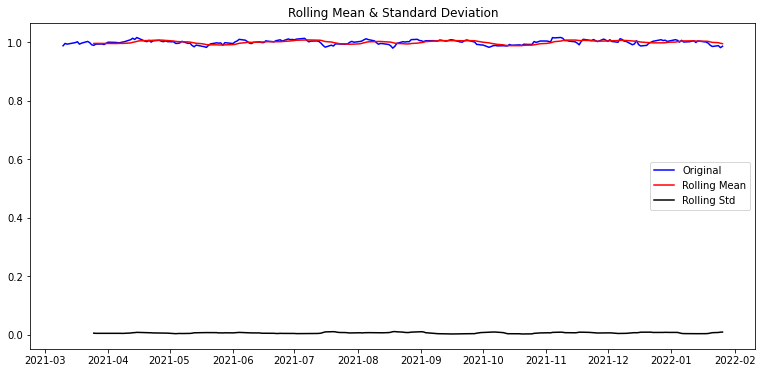

In [45]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual_NVIDIA)

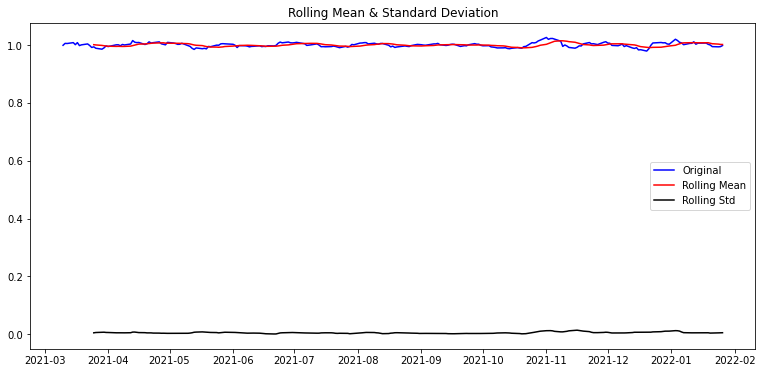

In [46]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual_TESLA)

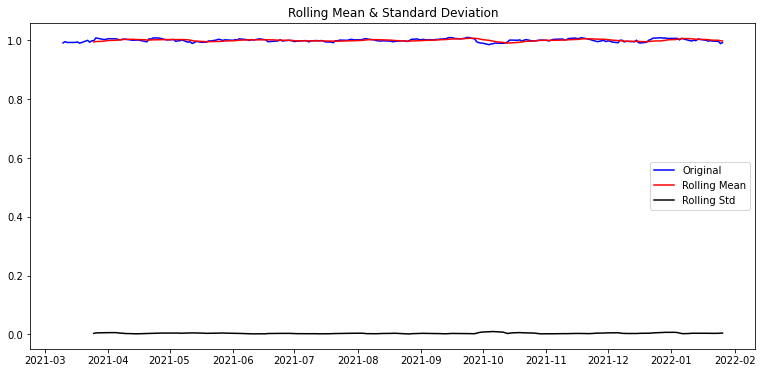

In [47]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual_ASML)

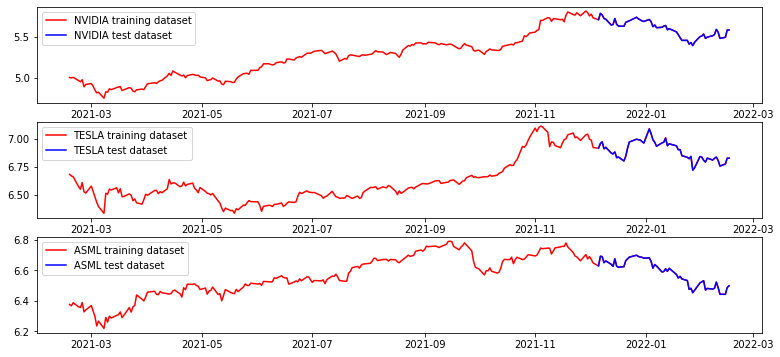

In [49]:
train_data_NVIDIA, test_data_NVIDIA = ts_NVIDIA[:int(len(ts_NVIDIA)*0.8)], ts_NVIDIA[int(len(ts_NVIDIA)*0.8):]
train_data_TESLA, test_data_TESLA = ts_TESLA[:int(len(ts_TESLA)*0.8)], ts_TESLA[int(len(ts_TESLA)*0.8):]
train_data_ASML, test_data_ASML = ts_ASML[:int(len(ts_ASML)*0.8)], ts_ASML[int(len(ts_ASML)*0.8):]

plt.subplot(311)
plt.plot(ts_NVIDIA, c='r', label='NVIDIA training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data_NVIDIA, c='b', label='NVIDIA test dataset')
plt.legend(loc='best')
plt.subplot(312)
plt.plot(ts_TESLA, c='r', label='TESLA training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data_TESLA, c='b', label='TESLA test dataset')
plt.legend(loc='best')
plt.subplot(313)
plt.plot(ts_ASML, c='r', label='ASML training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data_ASML, c='b', label='ASML test dataset')
plt.legend(loc='best')

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


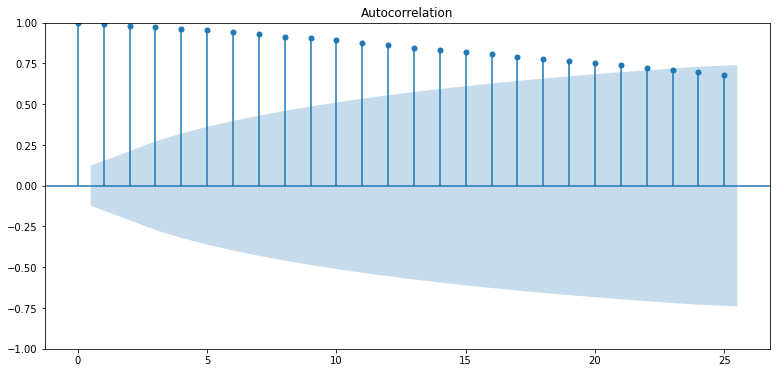

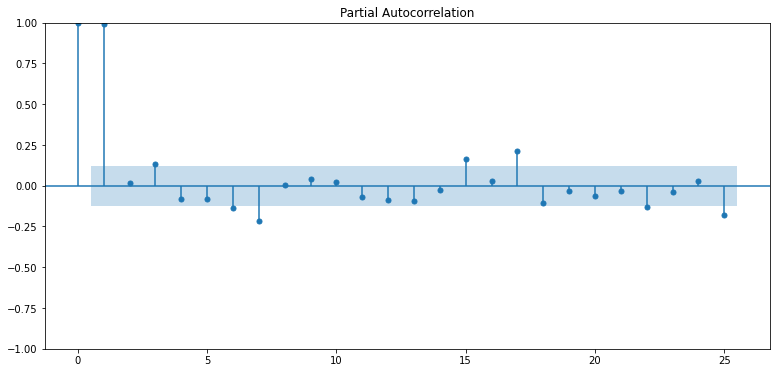

In [50]:
# ACF, PACF 그려보기 -> p,q 구하기
plot_acf(ts_NVIDIA)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_NVIDIA)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


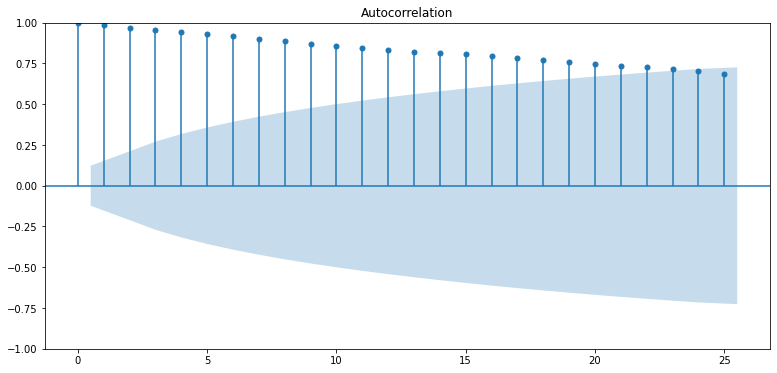

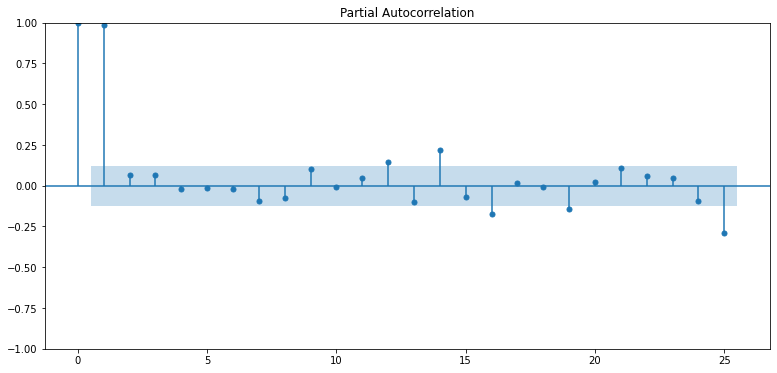

In [51]:
# ACF, PACF 그려보기 -> p,q 구하기
plot_acf(ts_TESLA)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_TESLA)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


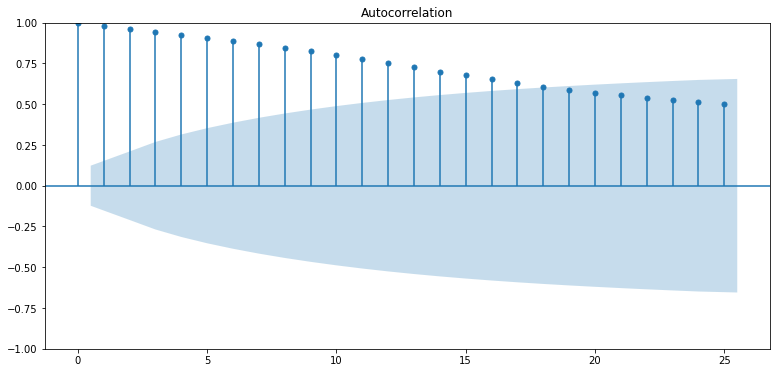

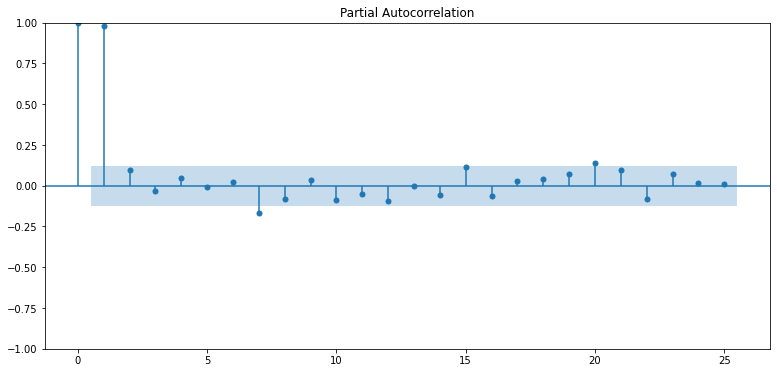

In [52]:
# ACF, PACF 그려보기 -> p,q 구하기
plot_acf(ts_ASML)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_ASML)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -5.267741
p-value                          0.000006
#Lags Used                       5.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


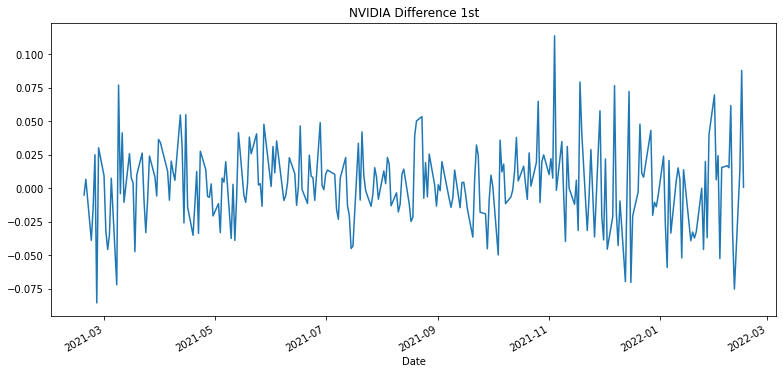

In [53]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1_NVIDIA = ts_NVIDIA.diff(periods=1).iloc[1:]
diff_1_NVIDIA.plot(title='NVIDIA Difference 1st')

augmented_dickey_fuller_test(diff_1_NVIDIA)

Results of Dickey-Fuller Test:
Test Statistic                -1.683248e+01
p-value                        1.155026e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.520000e+02
Critical Value (1%)           -3.456569e+00
Critical Value (5%)           -2.873079e+00
Critical Value (10%)          -2.572919e+00
dtype: float64


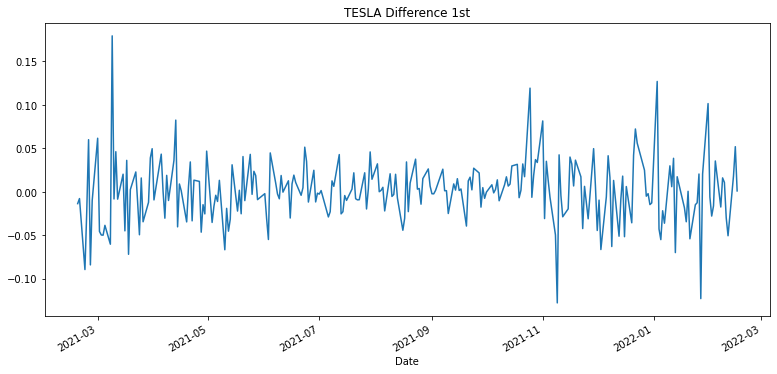

In [55]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1_TESLA = ts_TESLA.diff(periods=1).iloc[1:]
diff_1_TESLA.plot(title='TESLA Difference 1st')

augmented_dickey_fuller_test(diff_1_TESLA)

Results of Dickey-Fuller Test:
Test Statistic                -1.803262e+01
p-value                        2.673314e-30
#Lags Used                     0.000000e+00
Number of Observations Used    2.520000e+02
Critical Value (1%)           -3.456569e+00
Critical Value (5%)           -2.873079e+00
Critical Value (10%)          -2.572919e+00
dtype: float64


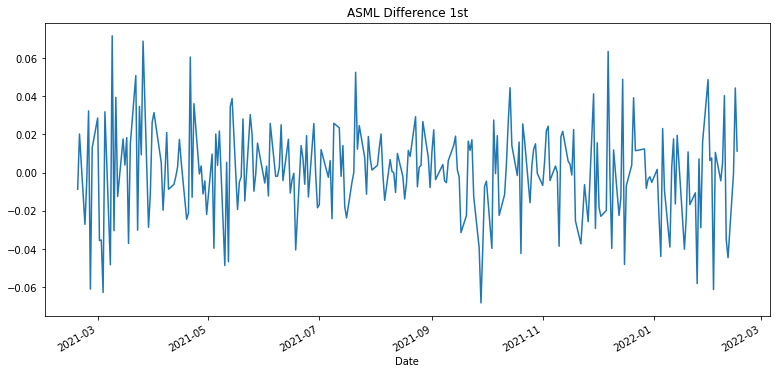

In [56]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1_ASML = ts_ASML.diff(periods=1).iloc[1:]
diff_1_ASML.plot(title='ASML Difference 1st')

augmented_dickey_fuller_test(diff_1_ASML)

Results of Dickey-Fuller Test:
Test Statistic                -8.007671e+00
p-value                        2.244862e-12
#Lags Used                     1.000000e+01
Number of Observations Used    2.410000e+02
Critical Value (1%)           -3.457779e+00
Critical Value (5%)           -2.873609e+00
Critical Value (10%)          -2.573202e+00
dtype: float64


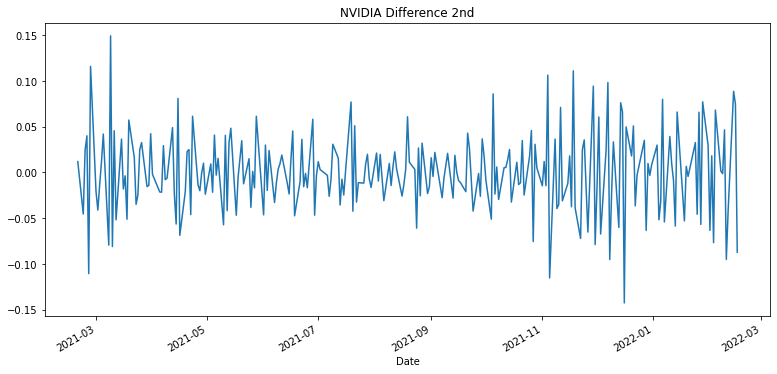

In [57]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2_NVIDIA = diff_1_NVIDIA.diff(periods=1).iloc[1:]
diff_2_NVIDIA.plot(title='NVIDIA Difference 2nd')

augmented_dickey_fuller_test(diff_2_NVIDIA)

Results of Dickey-Fuller Test:
Test Statistic                -7.198159e+00
p-value                        2.404162e-10
#Lags Used                     1.600000e+01
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


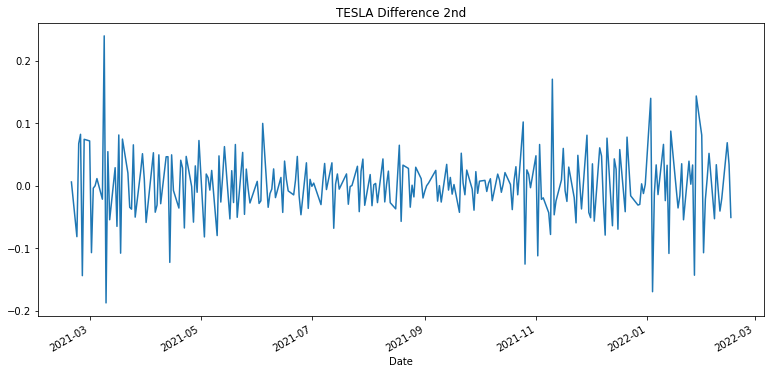

In [58]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2_TESLA = diff_1_TESLA.diff(periods=1).iloc[1:]
diff_2_TESLA.plot(title='TESLA Difference 2nd')

augmented_dickey_fuller_test(diff_2_TESLA)

Results of Dickey-Fuller Test:
Test Statistic                -9.743563e+00
p-value                        8.370754e-17
#Lags Used                     7.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64


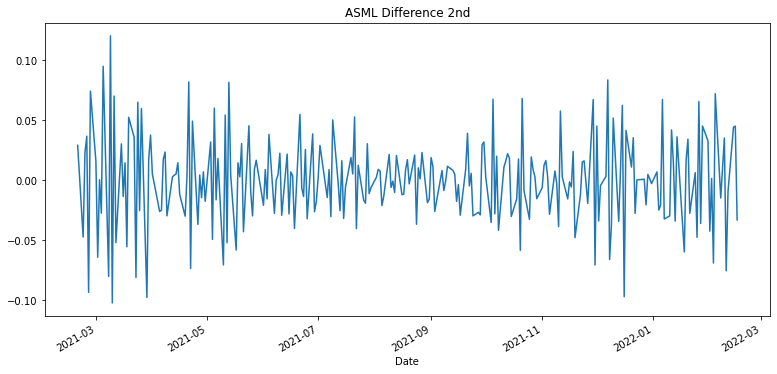

In [59]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2_ASML = diff_1_ASML.diff(periods=1).iloc[1:]
diff_2_ASML.plot(title='ASML Difference 2nd')

augmented_dickey_fuller_test(diff_2_ASML)

In [60]:
model_NVIDIA = ARIMA(train_data_NVIDIA, order=(2, 0, 1))  
model_TESLA = ARIMA(train_data_TESLA, order=(2, 0, 1))  
model_ASML = ARIMA(train_data_ASML, order=(2, 0, 1))  
fitted_m_NVIDIA = model_NVIDIA.fit() 
fitted_m_TESLA = model_TESLA.fit() 
fitted_m_ASML = model_ASML.fit() 


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequenc

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


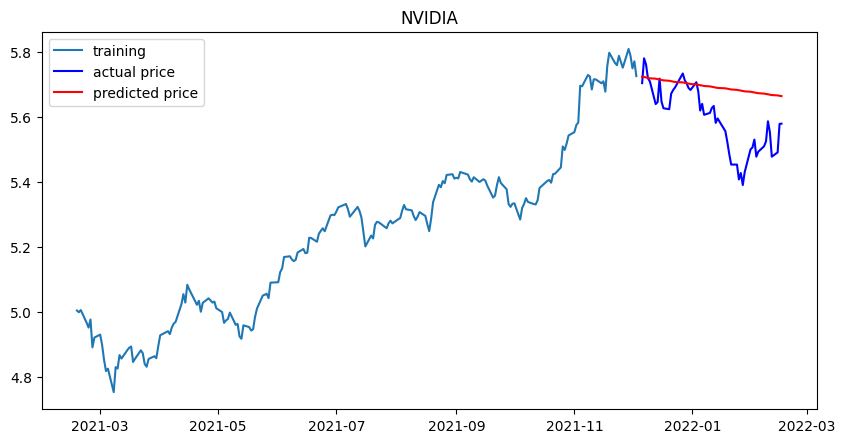

MSE:  1214.550717859296
MAE:  28.099508224536102
RMSE:  34.85040484498417
MAPE: 11.23%


In [64]:
# Forecast : 결과가 fc에 담깁니다. 
fc_NVIDIA = fitted_m_NVIDIA.forecast(len(test_data_NVIDIA), alpha=0.05)  # 95% conf
fc_NVIDIA = np.array(fc_NVIDIA)
# Make as pandas series
fc_series_NVIDIA = pd.Series(fc_NVIDIA, index=test_data_NVIDIA.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data_NVIDIA, label='training')
plt.plot(test_data_NVIDIA, c='b', label='actual price')
plt.plot(fc_series_NVIDIA, c='r',label='predicted price')
plt.title("NVIDIA")
plt.legend()
plt.show()

mse = mean_squared_error(np.exp(test_data_NVIDIA), np.exp(fc_NVIDIA))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data_NVIDIA), np.exp(fc_NVIDIA))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data_NVIDIA), np.exp(fc_NVIDIA)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc_NVIDIA) - np.exp(test_data_NVIDIA))/np.abs(np.exp(test_data_NVIDIA)))
print('MAPE: {:.2f}%'.format(mape*100))

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


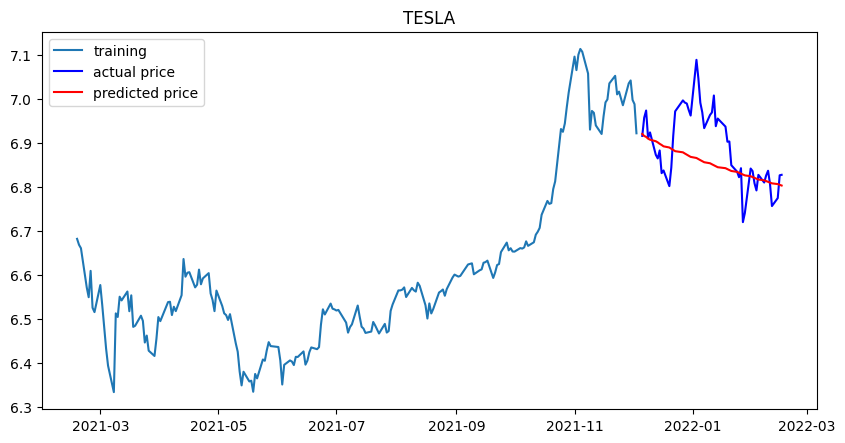

MSE:  6618.918758719563
MAE:  61.3915884232164
RMSE:  81.35673763567196
MAPE: 5.96%


In [65]:
# Forecast : 결과가 fc에 담깁니다. 
fc_TESLA = fitted_m_TESLA.forecast(len(test_data_TESLA), alpha=0.05)  # 95% conf
fc_TESLA = np.array(fc_TESLA)
# Make as pandas series
fc_series_TESLA = pd.Series(fc_TESLA, index=test_data_TESLA.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data_TESLA, label='training')
plt.plot(test_data_TESLA, c='b', label='actual price')
plt.plot(fc_series_TESLA, c='r',label='predicted price')
plt.title("TESLA")
plt.legend()
plt.show()

mse = mean_squared_error(np.exp(test_data_TESLA), np.exp(fc_TESLA))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data_TESLA), np.exp(fc_TESLA))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data_TESLA), np.exp(fc_TESLA)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc_TESLA) - np.exp(test_data_TESLA))/np.abs(np.exp(test_data_TESLA)))
print('MAPE: {:.2f}%'.format(mape*100))

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


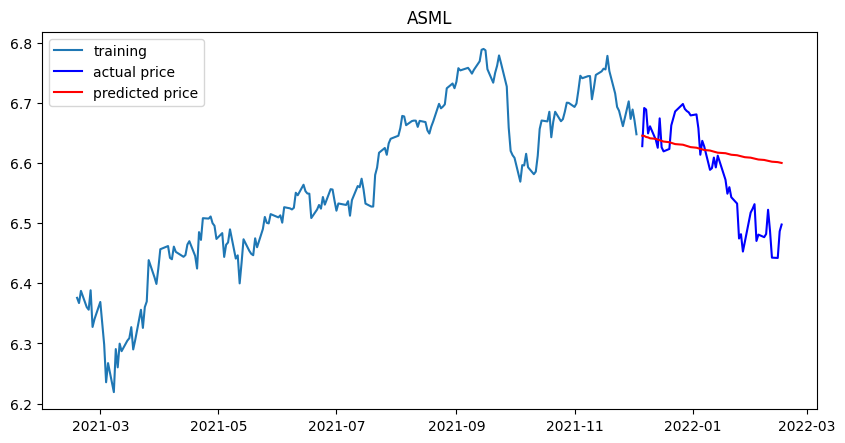

MSE:  3126.6691104890147
MAE:  45.73517860407891
RMSE:  55.916626422639396
MAPE: 6.63%


In [66]:
# Forecast : 결과가 fc에 담깁니다. 
fc_ASML = fitted_m_ASML.forecast(len(test_data_ASML), alpha=0.05)  # 95% conf
fc_ASML = np.array(fc_ASML)
# Make as pandas series
fc_series_ASML = pd.Series(fc_ASML, index=test_data_ASML.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data_ASML, label='training')
plt.plot(test_data_ASML, c='b', label='actual price')
plt.plot(fc_series_ASML, c='r',label='predicted price')
plt.title("ASML")
plt.legend()
plt.show()

mse = mean_squared_error(np.exp(test_data_ASML), np.exp(fc_ASML))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data_ASML), np.exp(fc_ASML))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data_ASML), np.exp(fc_ASML)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc_ASML) - np.exp(test_data_ASML))/np.abs(np.exp(test_data_ASML)))
print('MAPE: {:.2f}%'.format(mape*100))

# 회고
1. 생각외로 MAPE값이 모두 15%이하로 나와 신기했다.
2. 마지막에 3개의 주식을 통해 다시 해보는 부분에서 함수로 만들었다면 좀 더 코드가 깔끔해지지 않았을까 후회된다.
3. 시간이 된다면 다시 처음부터 파보고 싶은 EX였다.